LOADING THE DATA

In [11]:
import pandas as pd
import numpy as np

data = pd.read_csv('/Users/elvisechefu/Desktop/DT Project /languages.csv')
data.head()

,text,language
0,ich denke es handelt sich hier um ein missvers...,german
1,ich habe tom gerade erst verlassen,german
2,tom versuchte mary nur zu ärgern,german
3,tom hat mir die hand geküsst,german
4,ich wusste dass dir das gefiele,german


DATA ANALYSIS

In [12]:
# Get all unique languages values
print(data.groupby('language').nunique())
print(f"Total Length of dataset: {len(data)}")


# Check for missing values
print(data.isnull().sum())


# Explore the columns and their types
print(data.info())

            text
language        
english   275687
french    169693
german    199618
spanish   118686
Total Length of dataset: 763684
text        0
language    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763684 entries, 0 to 763683
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   text      763684 non-null  object
 1   language  763684 non-null  object
dtypes: object(2)
memory usage: 11.7+ MB
None


DATA VISUALIZATION

<Axes: xlabel='language', ylabel='count'>

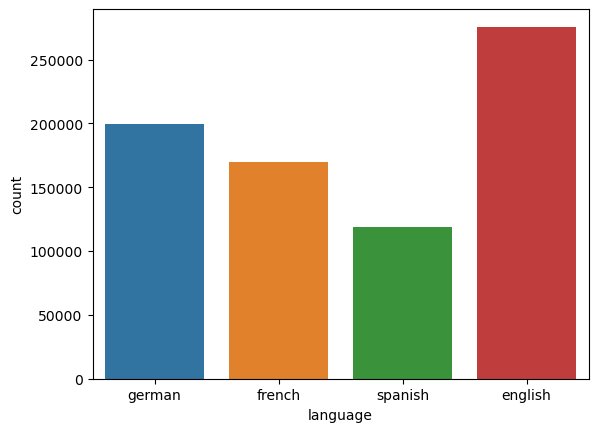

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x='language', data=data)

ONEHOT ENCODER 

In [14]:
language =pd.get_dummies(data.language)
datanew = pd.concat([data, language], axis=1)
datanew = datanew.drop(columns='language')
datanew

,text,english,french,german,spanish
0,ich denke es handelt sich hier um ein missvers...,False,False,True,False
1,ich habe tom gerade erst verlassen,False,False,True,False
2,tom versuchte mary nur zu ärgern,False,False,True,False
3,tom hat mir die hand geküsst,False,False,True,False
4,ich wusste dass dir das gefiele,False,False,True,False
...,...,...,...,...,...
763679,its so noisy here i cant hear myself think,True,False,False,False
763680,i was born before you,True,False,False,False
763681,i promise ill be quiet,True,False,False,False
763682,this isnt french,True,False,False,False


In [15]:
X = datanew['text'].values
y = datanew[['english', 'french', 'german', 'spanish']].values

In [16]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Print the shapes of the resulting sets
print("Train set shapes:", X_train.shape, y_train.shape)
print("Validation set shapes:", X_val.shape, y_val.shape)
print("Test set shapes:", X_test.shape, y_test.shape)


Train set shapes: (458210,) (458210, 4)
Validation set shapes: (152737,) (152737, 4)
Test set shapes: (152737,) (152737, 4)


In [17]:
#from sklearn.model_selection import train_test_split
#text_train, text_val, label_train, label_val = train_test_split(text, label, test_size=0.2)

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

TOKENIZATION OF THE SPLIT DATASETS

In [19]:
tokenizer = Tokenizer(num_words=8000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_val)


IMPLEMENTATION OF PADDED SEQUENCE

In [20]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_val = tokenizer.texts_to_sequences(X_val)
sequences_test = tokenizer.texts_to_sequences(X_test)

padded_train = pad_sequences(sequences_train) 
padded_val = pad_sequences(sequences_val)
padded_test = pad_sequences(sequences_test)

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [22]:
model = Sequential([
    Embedding(input_dim=8000, output_dim=64),
    LSTM(32),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          512000    
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 128)               4224      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 537,156
Trainable params: 537,156
Non-trai

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(),  # Include precision metric
                       tf.keras.metrics.Recall(),  # Include recall metric
                       tf.keras.metrics.AUC()])


In [24]:
class mycb(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= 0.92 and logs.get('val_accuracy') >= 0.92:
            print('\nFor Epoch', epoch, '\nAccuracy has reached %2.2f%%' % (logs['accuracy'] * 100), 'stopping training.')
            self.model.stop_training = True

In [25]:
fitmodel = model.fit(padded_train, y_train,
                     steps_per_epoch=25, epochs=50, 
                     validation_data=(padded_val, y_val), validation_steps=5,
                     verbose=2, callbacks=[mycb()]
                     )


Epoch 1/50


2024-03-06 16:29:04.077720: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


25/25 - 62s - loss: 1.2753 - accuracy: 0.4225 - precision: 0.9781 - recall: 0.0582 - auc: 0.7008 - val_loss: 0.9802 - val_accuracy: 0.6584 - val_precision: 0.9966 - val_recall: 0.3394 - val_auc: 0.8715 - 62s/epoch - 2s/step
Epoch 2/50
25/25 - 58s - loss: 0.6271 - accuracy: 0.7841 - precision: 0.9572 - recall: 0.6174 - auc: 0.9413 - val_loss: 0.3009 - val_accuracy: 0.8441 - val_precision: 0.9286 - val_recall: 0.8374 - val_auc: 0.9910 - 58s/epoch - 2s/step
Epoch 3/50

For Epoch 2 
Accuracy has reached 93.39% stopping training.
25/25 - 55s - loss: 0.1949 - accuracy: 0.9339 - precision: 0.9657 - recall: 0.8983 - auc: 0.9958 - val_loss: 0.0714 - val_accuracy: 0.9853 - val_precision: 0.9900 - val_recall: 0.9819 - val_auc: 0.9995 - 55s/epoch - 2s/step


In [26]:
# Prepare test data
sequences_test = tokenizer.texts_to_sequences(X_test)
padded_test = pad_sequences(sequences_test)

# Evaluate model on test data
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(padded_test, y_test)
print(test_loss)
print(test_accuracy)
print(test_precision)
print(test_recall)
print( test_auc)


4774/4774 [==============================] - 12s 2ms/step - loss: 0.0674 - accuracy: 0.9869 - precision: 0.9911 - recall: 0.9840 - auc: 0.9996
0.0673624575138092
0.986866295337677
0.9911102056503296
0.9839593768119812
0.9996064305305481


In [27]:
train_accuracy = fitmodel.history['accuracy']
train_recall = fitmodel.history['recall']
train_precision = fitmodel.history['precision']
train_loss = fitmodel.history['loss']
train_auc = fitmodel.history['auc']

print(train_accuracy)
print(train_recall)
print(train_precision)
print(train_loss)
print(train_auc)

[0.4225049614906311, 0.7840553522109985, 0.93389493227005]
[0.0582200288772583, 0.6174024939537048, 0.898334801197052]
[0.9781110286712646, 0.9571919441223145, 0.9656643271446228]
[1.275283694267273, 0.6271024942398071, 0.19494372606277466]
[0.7007536888122559, 0.9412909150123596, 0.9958137273788452]
